# Random Forest Classifier Model Training

## Website Phishing Dataset

This dataset is obtained from the UC Irvine Machine Learning Repository archive. According to this archive, the dataset provides valuable features for identifying potential phishing attempts https://archive.ics.uci.edu/dataset/379/website+phishing. 

According to that, the dataset was compiled by collecting URLs from a total of 1353 different websites. These phishing website URLs were collected from the PhishTank Data Archive, which is a free community site where users can submit, verify, track, and share phishing data. Legitimate websites were collected from Yahoo and origin directories using a web script developed in PHP.


* **Dataset:** Website Phishing Dataset
* **Content:** Data on various features of URLs to determine if they are legitimate, suspicious, or phishing
* **Number of Rows:** 1353
* **Number of Columns:** 10 (9 features + 1 class label)
* **Distribution:** 548 legitimate URLs, 702 phishing URLs, 103 suspicious URLs

### Features

| Feature | Description | Example |
|---------|-------------|---------|
| **SFH** | Where the website's form data is submitted to | Legitimate: form action="same-domain.com/submit" <br> Phishing: form action="different-domain.com/collect" |
| **popUpWindow** | Whether the website has popup windows | Legitimate: No popups on banking.com <br> Phishing: Multiple popups on banking-secure-verify.com |
| **SSLfinal_State** | Status of the SSL certificate | Legitimate: https://amazon.com (valid certificate) <br> Phishing: http://amaz0n-account-verify.com (no HTTPS) |
| **Request_URL** | Where images and other resources are loaded from | Legitimate: Images loaded from facebook.com on facebook.com <br> Phishing: Images from facebook.com on faceb00k-login.com |
| **URL_of_Anchor** | Where links on the page point to | Legitimate: Links on paypal.com point to paypal.com <br> Phishing: Links on paypa1.com point to different domains |
| **web_traffic** | How popular the website is | Legitimate: High traffic on twitter.com <br> Phishing: Very low traffic on twltter-verify.com |
| **URL_Length** | How long the URL is | Legitimate: google.com <br> Phishing: google-account-verify-secure-login-session-confirm.com |
| **age_of_domain** | How old the domain is | Legitimate: microsoft.com (registered decades ago) <br> Phishing: microsoft-update-security.com (registered last week) |
| **having_IP_Address** | If the URL uses an IP address instead of a domain name | Legitimate: netflix.com <br> Phishing: http://192.168.1.1/netflix/ |
| **Result** | The classification of the URL | Legitimate (1): amazon.com <br> Suspicious (0): amazon-offers2023.com <br> Phishing (-1): amaz0n-login-secure.com |


## Impor libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv("../data/Website Phishing.csv")
df.columns = df.columns.str.lower()

print(f'Data shape (rows, columns): {df.shape}')
print(f'Number of duplicate rows: {df.duplicated().sum()}')
print(f'Number of missing values: {df.isnull().sum().sum()}\n')

df.info()
df.head()

Data shape (rows, columns): (1353, 10)
Number of duplicate rows: 629
Number of missing values: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   sfh                1353 non-null   int64
 1   popupwidnow        1353 non-null   int64
 2   sslfinal_state     1353 non-null   int64
 3   request_url        1353 non-null   int64
 4   url_of_anchor      1353 non-null   int64
 5   web_traffic        1353 non-null   int64
 6   url_length         1353 non-null   int64
 7   age_of_domain      1353 non-null   int64
 8   having_ip_address  1353 non-null   int64
 9   result             1353 non-null   int64
dtypes: int64(10)
memory usage: 105.8 KB


,sfh,popupwidnow,sslfinal_state,request_url,url_of_anchor,web_traffic,url_length,age_of_domain,having_ip_address,result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [3]:
# Basic statistics 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sfh,1353.0,0.237990,0.916389,-1.0,-1.0,1.0,1.0,1.0
popupwidnow,1353.0,-0.258684,0.679072,-1.0,-1.0,0.0,0.0,1.0
sslfinal_state,1353.0,0.327421,0.822193,-1.0,0.0,1.0,1.0,1.0
request_url,1353.0,-0.223208,0.799682,-1.0,-1.0,0.0,0.0,1.0
url_of_anchor,1353.0,-0.025129,0.936262,-1.0,-1.0,0.0,1.0,1.0
web_traffic,1353.0,0.000000,0.806776,-1.0,-1.0,0.0,1.0,1.0
url_length,1353.0,-0.053215,0.762552,-1.0,-1.0,0.0,1.0,1.0
age_of_domain,1353.0,0.219512,0.975970,-1.0,-1.0,1.0,1.0,1.0
having_ip_address,1353.0,0.114560,0.318608,0.0,0.0,0.0,0.0,1.0
result,1353.0,-0.113821,0.954773,-1.0,-1.0,-1.0,1.0,1.0


In [4]:
# Summary of Numeric Features 

def numeric_summary(df):
    obs = df.shape[0]
    
    numeric_df = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': numeric_df.dtypes, 
        'Counts': numeric_df.apply(lambda x: x.count()), 
        'Nulls': numeric_df.apply(lambda x: x.isnull().sum()), 
        'NullPercent': (numeric_df.isnull().sum() / obs) * 100,
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Uniques': numeric_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': numeric_df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else '-')
    })
    
    print('___________________________\nData Types:')
    print(summary_df['Dtype'].value_counts())
    print('___________________________')
    print('Numreical Features Summary:')
    
    return summary_df


numeric_summary(df)

___________________________
Data Types:
Dtype
int64    10
Name: count, dtype: int64
___________________________
Numreical Features Summary:


,Dtype,Counts,Nulls,NullPercent,Min,Max,Uniques,UniqueValues
sfh,int64,1353,0,0.0,-1,1,3,"[1, -1, 0]"
popupwidnow,int64,1353,0,0.0,-1,1,3,"[-1, 0, 1]"
sslfinal_state,int64,1353,0,0.0,-1,1,3,"[1, -1, 0]"
request_url,int64,1353,0,0.0,-1,1,3,"[-1, 0, 1]"
url_of_anchor,int64,1353,0,0.0,-1,1,3,"[-1, 0, 1]"
web_traffic,int64,1353,0,0.0,-1,1,3,"[1, 0, -1]"
url_length,int64,1353,0,0.0,-1,1,3,"[1, -1, 0]"
age_of_domain,int64,1353,0,0.0,-1,1,2,"[1, -1]"
having_ip_address,int64,1353,0,0.0,0,1,2,"[0, 1]"
result,int64,1353,0,0.0,-1,1,3,"[0, 1, -1]"


In [6]:
# User defined fonction for counting and percentage values in the each column

def get_value_count(df, column_name):
    vc = df[column_name].value_counts()
    vc_norm = df[column_name].value_counts(normalize=True)

    vc = vc.rename_axis(column_name).reset_index(name='counts')
    vc_norm = vc_norm.rename_axis(column_name).reset_index(name='percent')

    df_result = pd.concat([vc[column_name], vc['counts'], vc_norm['percent']], axis=1)
    
    return df_result

## Distributions of the Target Feature: `Result` 

-  1: Legitimate
-  0: Suspicious
- -1: Phishing

In [7]:
get_value_count(df, 'result') 

# Total Number of values and percentage 

,result,counts,percent
0,-1,702,0.518847
1,1,548,0.405026
2,0,103,0.076127


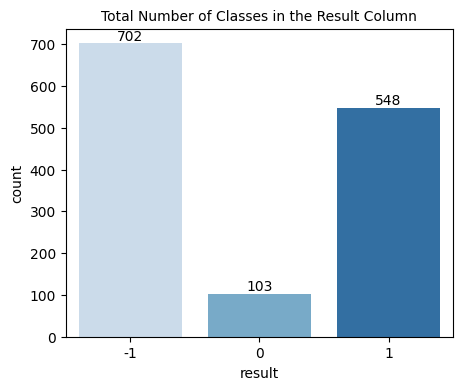

In [8]:
plt.figure(figsize=(5,4))
ax = sns.countplot( data=df, x="result", palette='Blues')

ax.bar_label(ax.containers[0])
ax.set_title('Total Number of Classes in the Result Column', size = 10);
plt.show()

### Converting Phishing (-1) to Suspicious (0)  

**NOTES!!**:

- The Suspicious (0) class has a very low number of values
- To mitigate this risk, we will merge the Suspicious (0) class with the Phishing (-1) class
- So we will have only 2 classes:
    - Legitimate URLs (1) (Good)
    - Phishing URLs (0) (Bad)

- The other feature columns were kept in their original form [-1, 0, 1 values] to preserve their semantic meaning and the model's learning capacity.
- Converting these feature columns would have resulted in the loss of important information since each value represents specific conditions that help the model make better distinctions between legitimate and phishing URLs.

In [20]:
# replace Suspicious (0) values with Phishing (-1) in the "Result columns"

df['result'] = df['result'].replace(-1, 0)

get_value_count(df, 'result') 

,result,counts,percent
0,0,805,0.594974
1,1,548,0.405026


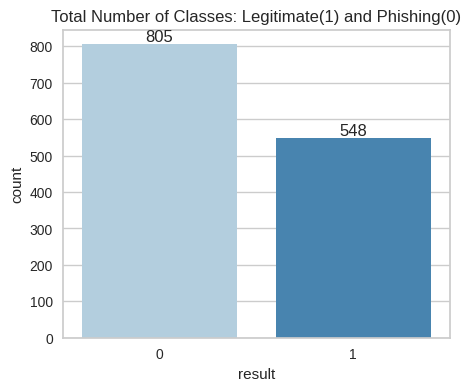

In [21]:
plt.figure(figsize=(5,4))
ax = sns.countplot( data=df, x="result", palette='Blues')

ax.bar_label(ax.containers[0])
ax.set_title('Total Number of Classes: Legitimate(1) and Phishing(0)', size = 12);
plt.show()

## Model Development

In [ ]:
#!pip install scikit-learn lightgbm xgboost lazypredict yellowbrick

In [11]:
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, GridSearchCV, StratifiedKFold

import pandas as pd
import numpy as np

# Metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from yellowbrick.classifier import PrecisionRecallCurve, ClassPredictionError, ROCAUC
from yellowbrick.regressor import ResidualsPlot, PredictionError

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Train | Test Split

In [23]:
#Splitting Data
X = df.drop('result', axis = 1)
y = df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


print('---------------------------------------------')
print("X_Train rows-columns: ", X_train.shape)
print("y_Train Target Feature rosw: ", y_train.shape)
print("X_Test Validation Data rows-columns: ", X_test.shape)
print('---------------------------------------------')
print("Prediction Test Dataset rows-columns: ", y_test.shape)
print('---------------------------------------------')

---------------------------------------------
X_Train rows-columns:  (1082, 9)
y_Train Target Feature rosw:  (1082,)
X_Test Validation Data rows-columns:  (271, 9)
---------------------------------------------
Prediction Test Dataset rows-columns:  (271,)
---------------------------------------------


In [24]:
X_train.head(3)

,sfh,popupwidnow,sslfinal_state,request_url,url_of_anchor,web_traffic,url_length,age_of_domain,having_ip_address
856,1,-1,0,1,1,0,-1,1,0
1297,1,0,1,-1,1,0,1,-1,0
1296,1,0,-1,1,1,1,1,-1,0


In [25]:
X_test.head(3)

,sfh,popupwidnow,sslfinal_state,request_url,url_of_anchor,web_traffic,url_length,age_of_domain,having_ip_address
673,1,0,1,1,1,1,1,1,1
552,1,0,1,-1,1,0,0,-1,0
226,1,1,1,-1,-1,-1,1,1,0


In [26]:
# User-Defined-Functions

#-----------------------------------------------------

# Function to Evaluate the Model Performans using Classification Confusion_matrix() 
# Also does the prediction in the function

def eval_metric(model, X_train, y_train, X_test, y_test, i):

    """ to get the metrics for the model """

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(f"{i} Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print(f"{i} Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    
# -----------------------------------------------------

# Function to display Feature Importance
def plot_feature_importance(model, X_train, model_name, figsize=(8, 5)):
    """
    Plots the feature importances of a fitted model as a horizontal bar plot,
    with the importance values displayed next to the bars.
    """
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a Series for feature importances
    feats = pd.Series(data=feature_importances, index=X_train.columns).sort_values(ascending=False)
    
    # Plot the feature importances as a horizontal bar plot
    plt.figure(figsize=figsize)
    sns.barplot(y=feats.index, x=feats.values, orient='h', palette='Blues')

    # Add the importance values next to the bars
    for index, value in enumerate(feats.values):
        plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

    # Add model name to the plot title
    plt.title(f"Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

## RandomForest Model

In [27]:
from sklearn.ensemble import RandomForestClassifier

# RF Hyperparameters Tuning with GridSearchSV 

# Reset the model
model = RandomForestClassifier(random_state=42)


param_grid = {           
            'n_estimators': [50,100],  
            'max_depth': [None, 2, 10],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2,5],
            'max_features': ['sqrt', 'log2'],
            'max_samples':[0.5, 0.9],
            "criterion": ["gini", "entropy"]
             }
             


cv = StratifiedKFold(n_splits=5)

# GridSearchCV
RFC_grid_model = GridSearchCV(model,
                          param_grid=param_grid,
                          cv=cv,
                          scoring="accuracy",  
                          n_jobs=4,          # Use all available cores
                          verbose=1,
                          return_train_score=True).fit(X_train, y_train) # Fit the grid search model

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [28]:
rfc_best_params = RFC_grid_model.best_params_
rfc_best_scores = RFC_grid_model.best_score_
print('Best Params:', rfc_best_params)
print('Best Recall Score(test):', rfc_best_scores)
print('-----------------------------------------------------')

# Checking overfiting of Grid Model with the CV scores
pd.DataFrame(RFC_grid_model.cv_results_).loc[RFC_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

Best Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Recall Score(test): 0.9158986175115207
-----------------------------------------------------


mean_test_score     0.915899
mean_train_score    0.942005
Name: 107, dtype: object

### Prediction with Best HyperParameters

In [29]:
# Create a new model with the best parameters from GridSearchCV
RFC_best_model  = RandomForestClassifier(
    **rfc_best_params,  # Unpack the best parameters dictionary
    random_state=42,
    #verbose=1
)

# Fit the model on the training data
RFC_best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [30]:
# Make predictions on test data
y_pred = RFC_best_model.predict(X_test)

# Evaluate the model
RFC_best_acc = accuracy_score(y_test, y_pred)
print('RFC_best_model_accuracy score with the Test prediction: ',RFC_best_acc, '\n')

target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))

RFC_best_model_accuracy score with the Test prediction:  0.915129151291513 

              precision    recall  f1-score   support

    Phishing       0.94      0.91      0.93       161
  Legitamite       0.88      0.92      0.90       110

    accuracy                           0.92       271
   macro avg       0.91      0.92      0.91       271
weighted avg       0.92      0.92      0.92       271



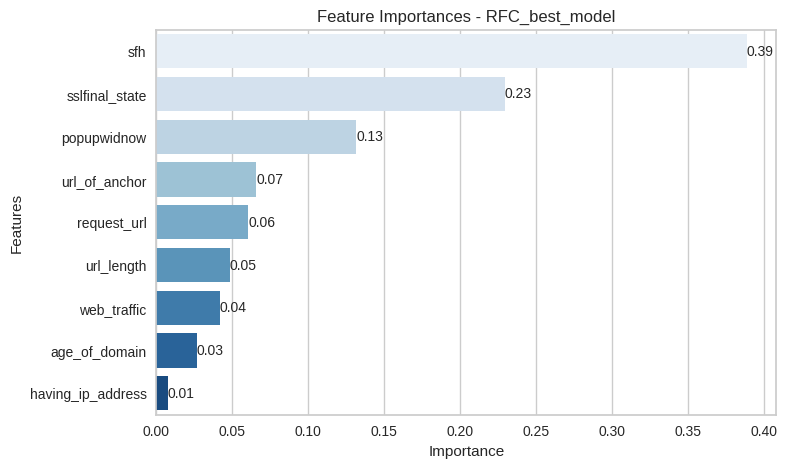

In [31]:
# Feature Importance
plot_feature_importance(RFC_best_model, X_test, 'RFC_best_model')

In [ ]:
# Save model

# import joblib

# joblib.dump(RFC_best_model, 'RFC_best_model.joblib')
# print("Model saved successfully")

In [32]:
# Save model

import pickle
with open('RFC_best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

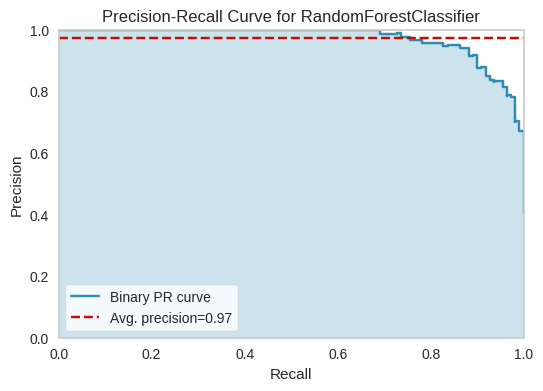

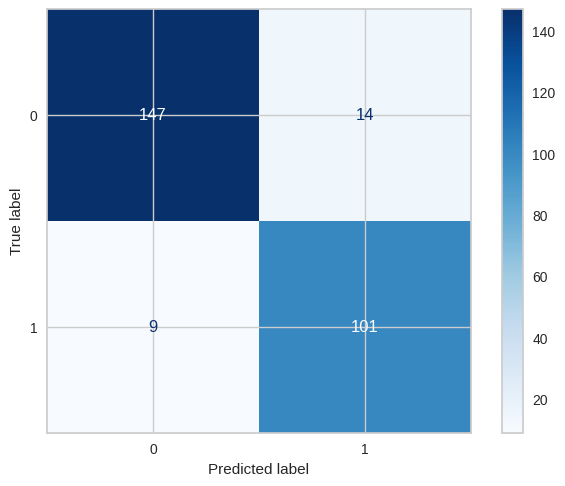

In [37]:
# Precision-Recall Curve
plt.figure(figsize=(6, 4))
viz = PrecisionRecallCurve(RFC_best_model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(RFC_best_model, X_test, y_test, cmap='Blues')

# Conclusion

RandomForestClassifier model performance:

- RFC model shows strong performance in classifying phishing versus legitimate cases:

    - **Accuracy**: 91.5% accuracy on the test set, meaning the model correctly classified about 9 out of 10 samples overall.
    - **Phishing Detection**: 94% precision and 91% recall for phishing cases. This means when the model predicts something is phishing, it's right 94% of the time, and it catches 91% of all actual phishing instances.
    - **Legitimate Classification**: 88% precision and 92% recall for legitimate cases. The model is slightly better at identifying legitimate cases (higher recall) than being confident about them (lower precision).
    - **Precision-Recall Curve**: The first image shows an excellent PR curve with an average precision of 0.97. The curve remains high across different recall thresholds, dropping only at very high recall values.
    - **Confusion Matrix**: The second image confirms excellent performance with 147 true negatives and 101 true positives. There are only 14 false positives and 9 false negatives.

In summary, this model performs very well for phishing detection with balanced precision and recall, making it reliable for practical application.